In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.metrics import mean_squared_error

from assets.graph_functions import plot_signal_data

import h5py
import warnings
from typing import Tuple

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

time_window = 2 * 1.2
fs = 360
n = 864

np.random.seed(42)
tf.random.set_seed(42)

tt = np.linspace(0, time_window, n)

In [197]:
ABC = 1

if ABC:
    xtrain = h5py.File('data/X_train_2.h5', 'r')
    ytrain = h5py.File('data/y_train_2.h5', 'r')
    xtest = h5py.File('data/X_test_2.h5', 'r')
    ytest = h5py.File('data/y_test_2.h5', 'r')
else:
    xtrain = h5py.File('data/X_train.h5', 'r')
    ytrain = h5py.File('data/y_train.h5', 'r')
    xtest = h5py.File('data/X_test.h5', 'r')
    ytest = h5py.File('data/y_test.h5', 'r')

xtrain_d = xtrain.get('X_train')
ytrain_d = ytrain.get('y_train')
xtest_d = xtest.get('X_test')
ytest_d = ytest.get('y_test')

In [199]:
X_train = xtrain_d[:]
y_train = ytrain_d[:]
X_test = xtest_d[:]
y_test = ytest_d[:]

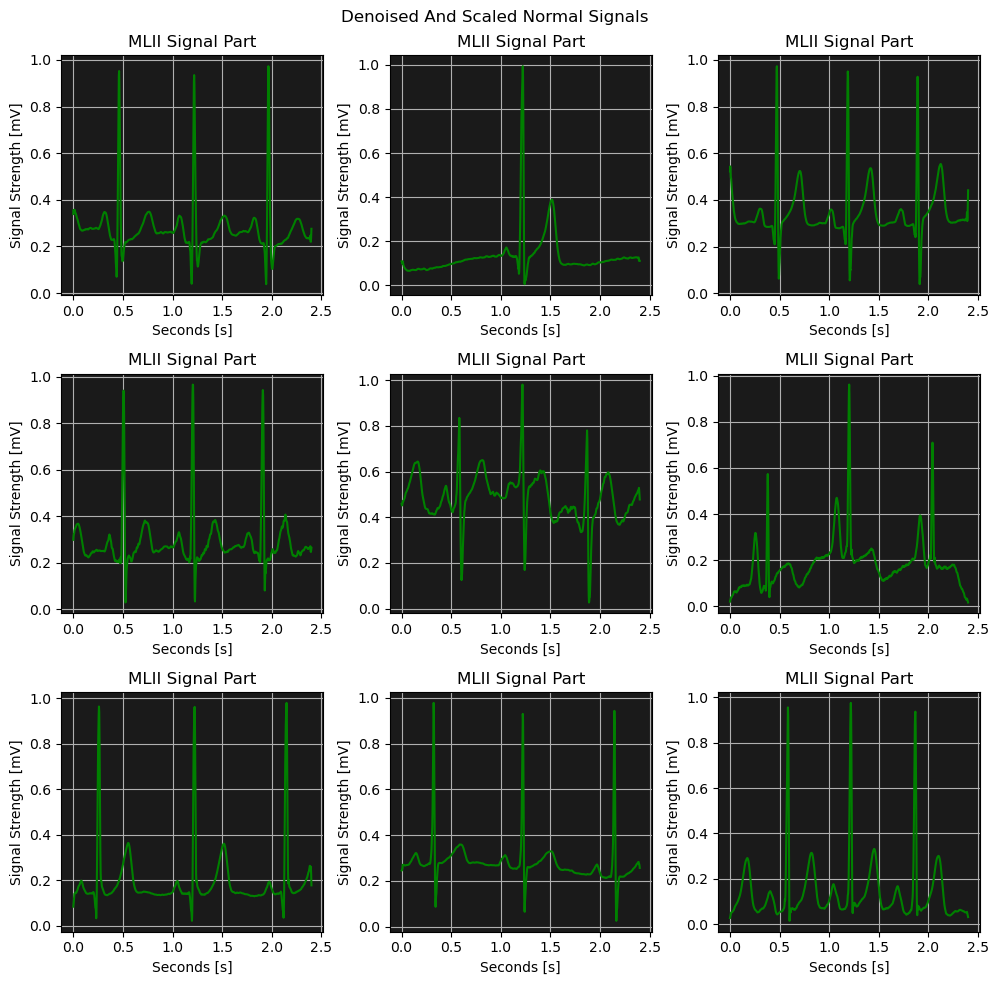

In [87]:
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3)

for ax, idx in zip(axes.flatten(), range(9)):
    plot_signal_data(ax, tt, X_train[idx])

fig.suptitle("Denoised And Scaled Normal Signals")
plt.tight_layout()
plt.show()

In [201]:
anomaly_ids = np.where(y_test == 1)
normal_ids = np.where(y_test == 0)

temp = X_test[anomaly_ids]
normal = X_test[normal_ids]

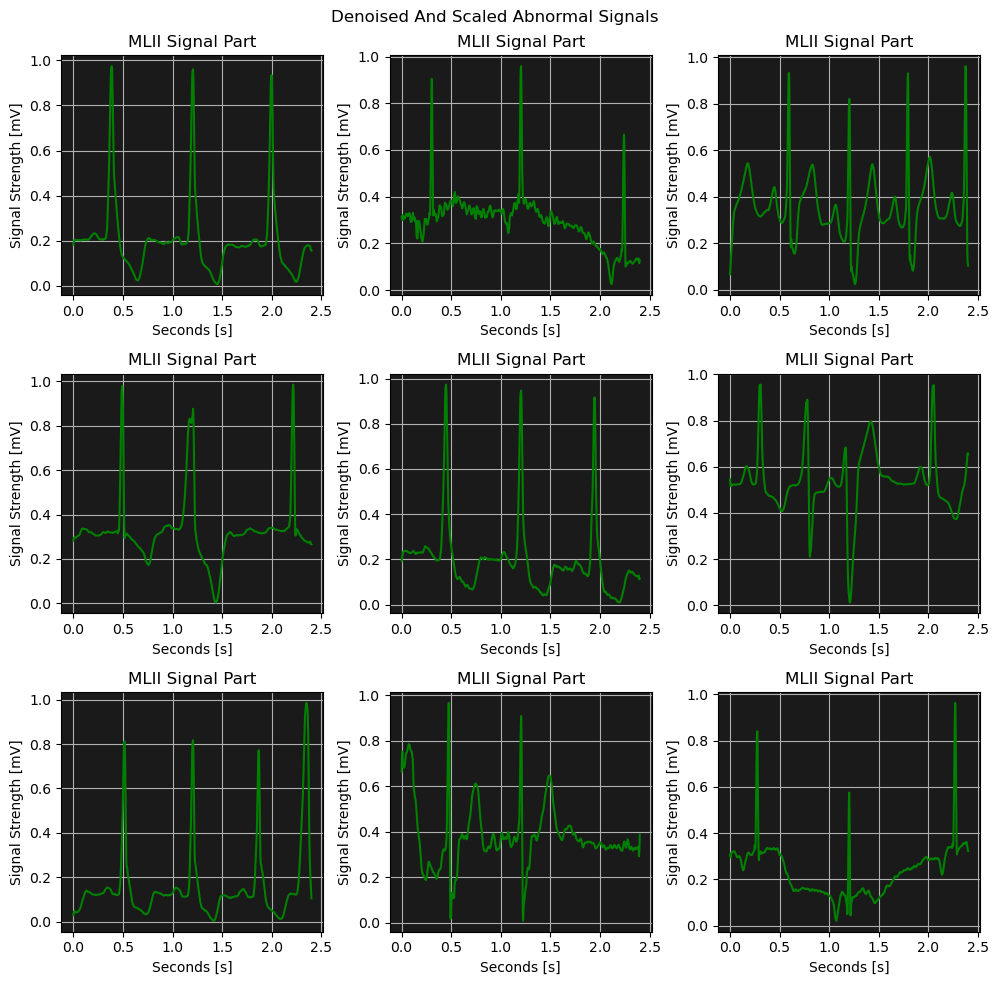

In [91]:
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3)

for ax in axes.flatten():
    plot_signal_data(ax, tt, temp[np.random.randint(0, len(temp)-1)])

fig.suptitle("Denoised And Scaled Abnormal Signals")
plt.tight_layout()
plt.show()

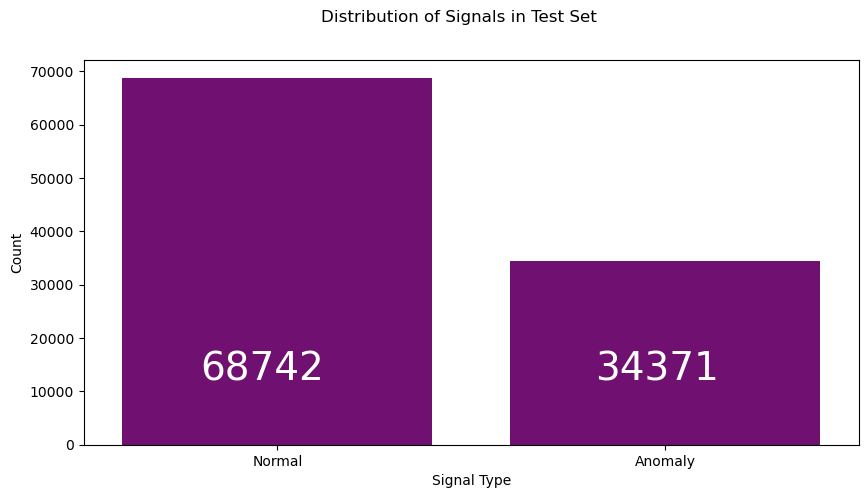

In [93]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=y_test, ax=ax, color="purple")
ax.annotate(len(normal), (-0.2, 12000), color="white", fontsize=28)
ax.annotate(len(temp), (0.82, 12000), color="white", fontsize=28)

ax.set_xticklabels(["Normal", "Anomaly"])
ax.set_xlabel("Signal Type")
ax.set_ylabel("Count")
fig.suptitle("Distribution of Signals in Test Set")

plt.show()

# Fully Connected AutoEncoder

In [95]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_cp_new_1.keras", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

input_shape = (X_train.shape[1], )  # signal length

encoder = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),  # laten space
])

decoder = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(16,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_shape[0], activation='sigmoid')
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ ?                           │          57,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ ?                           │          58,816 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,784 (456.19 KB)

 Trainable params: 116,784 (456.19 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
history = autoencoder.fit(
    X_train, 
    X_train,
    epochs=50, 
    batch_size=48, # 48
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0128 - val_loss: 0.0065
Epoch 2/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 3/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 4/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 5/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 11/50
5857/5857 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 12/50
5857/5857 

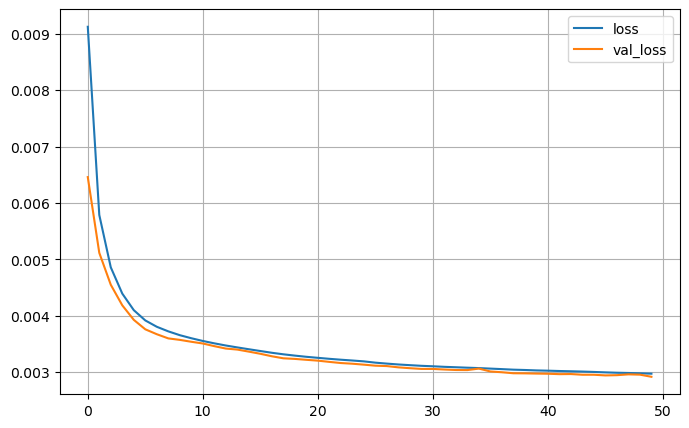

In [99]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [63]:
autoencoder = models.load_model("model_cp.keras")

In [101]:
test_decoded_1 = autoencoder.predict(np.array([normal[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [103]:
def plot_between_signals(ax: mpl.axes.Axes, x: np.array, y1: np.array, y2: np.array, plot_kws={}):
    ax.fill_between(x, y1, y2, **plot_kws)

    return ax

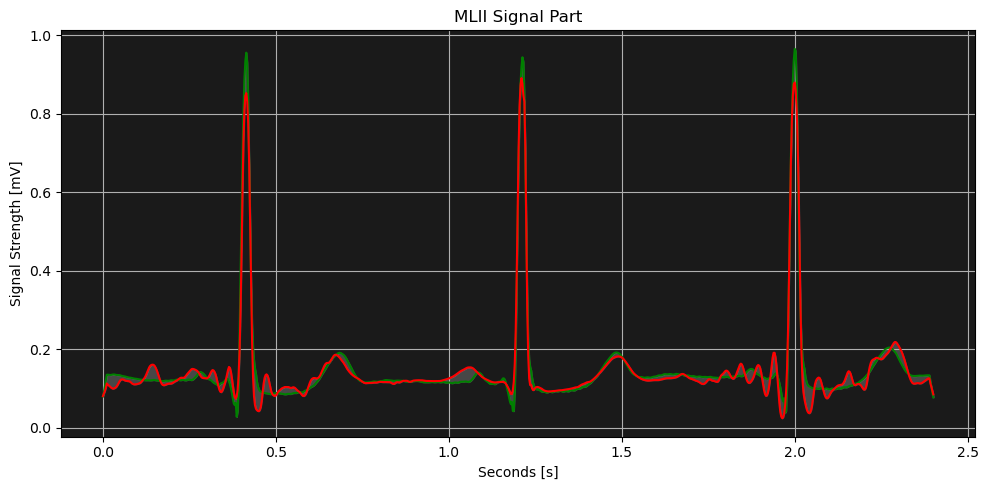

In [105]:
fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, tt, normal[0])
plot_signal_data(ax, tt, test_decoded_1[0], plot_kws={"c": "red"})
plot_between_signals(ax, tt, normal[0], test_decoded_1[0], plot_kws={"color": "white", "alpha": 0.2})

plt.grid()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


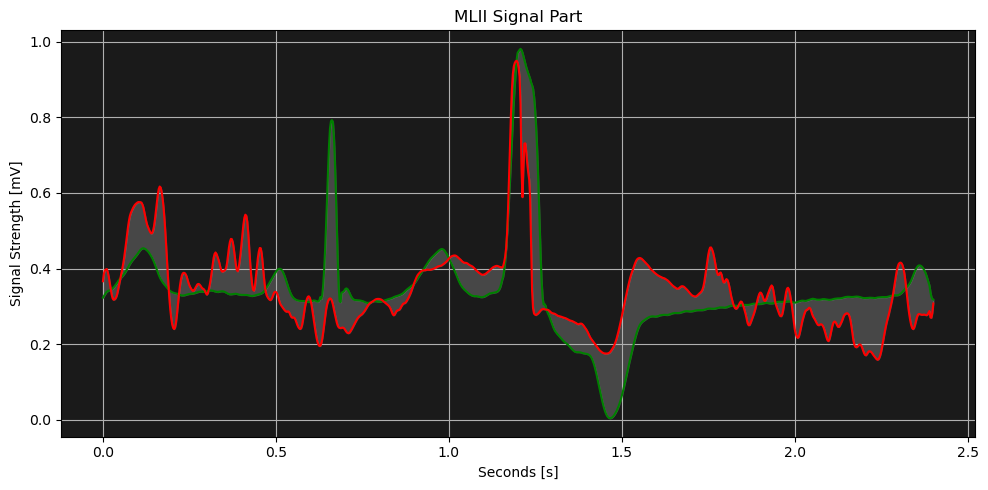

In [107]:
test_decoded_2 = autoencoder.predict(np.array([temp[50]]))

fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, tt, temp[50])
plot_signal_data(ax, tt, test_decoded_2[0], plot_kws={"c": "red"})
plot_between_signals(ax, tt, temp[50], test_decoded_2[0], plot_kws={"color": "white", "alpha": 0.2})

plt.grid()
plt.tight_layout()
plt.show()

In [109]:
test_signals = autoencoder.predict(X_test)

3223/3223 ━━━━━━━━━━━━━━━━━━━━ 3s 936us/step


In [110]:
reconstruction_error = np.mean(np.square(X_test - test_signals), axis=1)  # mse for every signal sample

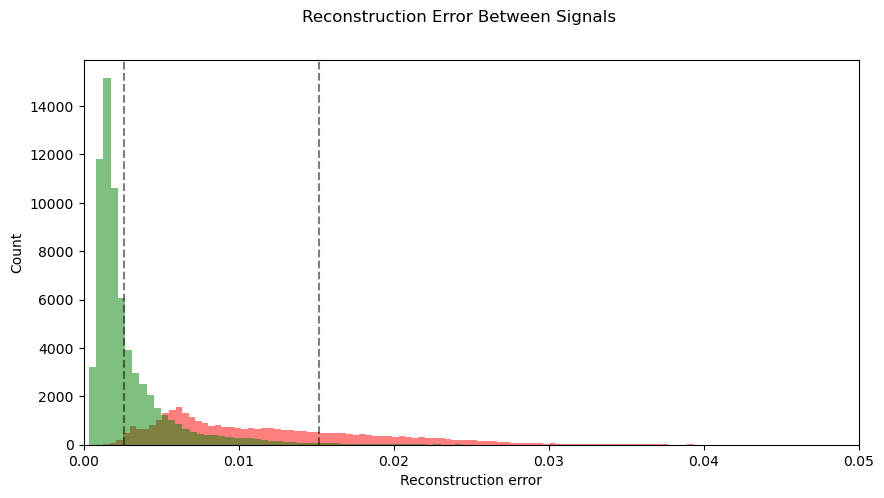

In [117]:
anomaly_q001 = np.quantile(reconstruction_error[anomaly_ids], 0.01)
normal_q099 = np.quantile(reconstruction_error[normal_ids], 0.99)

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(reconstruction_error[anomaly_ids], bins=200, color="red", alpha=0.5)
ax.hist(reconstruction_error[normal_ids], bins=300, color="green", alpha=0.5)

ax.axvline(x=anomaly_q001, color="black", alpha=0.5, linestyle="--")
ax.axvline(x=normal_q099, color="black", alpha=0.5, linestyle="--")

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Count")

fig.suptitle("Reconstruction Error Between Signals")

ax.set_xlim([0, 0.05])

plt.show()

fig.savefig("graphs/model1_fixeddata.png")

In [123]:
checkpoint_cb_2 = tf.keras.callbacks.ModelCheckpoint("model_cp2_new_2.keras", save_best_only=True)
early_stopping_cb_2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

input_shape = (X_train.shape[1], )  # signal length

encoder2 = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(64, activation=layers.LeakyReLU(alpha=0.01)),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    layers.Dense(16, activation=layers.LeakyReLU(alpha=0.01)),  # laten space
])

decoder2 = models.Sequential([
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01), input_shape=(16,)),
    layers.Dense(64, activation=layers.LeakyReLU(alpha=0.01)),
    layers.Dense(input_shape[0], activation='sigmoid')
])

autoencoder2 = models.Sequential([encoder2, decoder2])

autoencoder2.compile(optimizer='adam', loss='mse')

autoencoder2.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_18 (Sequential)           │ ?                           │          57,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ ?                           │          58,816 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,784 (456.19 KB)

 Trainable params: 116,784 (456.19 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
history2 = autoencoder2.fit(
    X_train, 
    X_train,
    epochs=100, 
    batch_size=128, # 256 
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint_cb_2, early_stopping_cb_2]
)

Epoch 1/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0151 - val_loss: 0.0077
Epoch 2/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 3/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 4/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 5/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 9/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 10/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 11/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 12/100
2197/2

3223/3223 ━━━━━━━━━━━━━━━━━━━━ 3s 844us/step


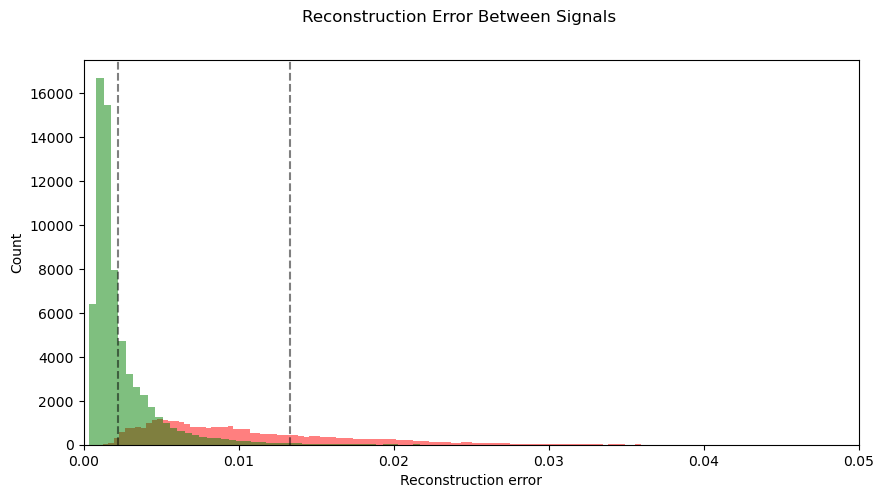

In [129]:
test_signals_2 = autoencoder2.predict(X_test)
reconstruction_error_2 = np.mean(np.square(X_test - test_signals_2), axis=1)  # mse for every signal sample

anomaly_q001_2 = np.quantile(reconstruction_error_2[anomaly_ids], 0.01)
normal_q099_2 = np.quantile(reconstruction_error_2[normal_ids], 0.99)

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(reconstruction_error_2[anomaly_ids], bins=200, color="red", alpha=0.5)
ax.hist(reconstruction_error_2[normal_ids], bins=300, color="green", alpha=0.5)

ax.axvline(x=anomaly_q001_2, color="black", alpha=0.5, linestyle="--")
ax.axvline(x=normal_q099_2, color="black", alpha=0.5, linestyle="--")

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Count")

fig.suptitle("Reconstruction Error Between Signals")

ax.set_xlim([0, 0.05])

plt.show()

fig.savefig("graphs/model2_fixeddata.png")

In [131]:
checkpoint_cb_3 = tf.keras.callbacks.ModelCheckpoint("model_cp3_new_3.keras", save_best_only=True)
early_stopping_cb_3 = tf.keras.callbacks.EarlyStopping(patience=10,
                                                       min_delta=0,
                                                       restore_best_weights=True)

log_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end = lambda epoch, logs: print(f"Epoch {epoch+1}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")
    if (epoch + 1) % 5 == 0 else None
)

optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.999)

input_shape = (X_train.shape[1], )  # signal length

encoder3 = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(64, activation=layers.LeakyReLU(alpha=0.01)),
    layers.BatchNormalization(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    layers.BatchNormalization(),
    layers.Dense(16, activation=layers.LeakyReLU(alpha=0.01)),  # laten space
    layers.BatchNormalization()
])

decoder3 = models.Sequential([
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01), input_shape=(16,)),
    layers.BatchNormalization(),
    layers.Dense(64, activation=layers.LeakyReLU(alpha=0.01)),
    layers.BatchNormalization(),
    layers.Dense(input_shape[0], activation='sigmoid')
])

autoencoder3 = models.Sequential([encoder3, decoder3])

autoencoder3.compile(optimizer=optimizer, loss='mse')

autoencoder3.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)           │ ?                           │          58,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_22 (Sequential)           │ ?                           │          59,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,616 (459.44 KB)

 Trainable params: 117,200 (457.81 KB)

 Non-trainable params: 416 (1.62 KB)

In [133]:
history3 = autoencoder3.fit(
    X_train, 
    X_train,
    epochs=100, 
    batch_size=64, # 128
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint_cb_3, early_stopping_cb_3]
)

Epoch 1/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0162 - val_loss: 0.0066
Epoch 2/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 3/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 4/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 5/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 6/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 7/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 8/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 9/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 10/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 11/100
4393/4393 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 12

3223/3223 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step


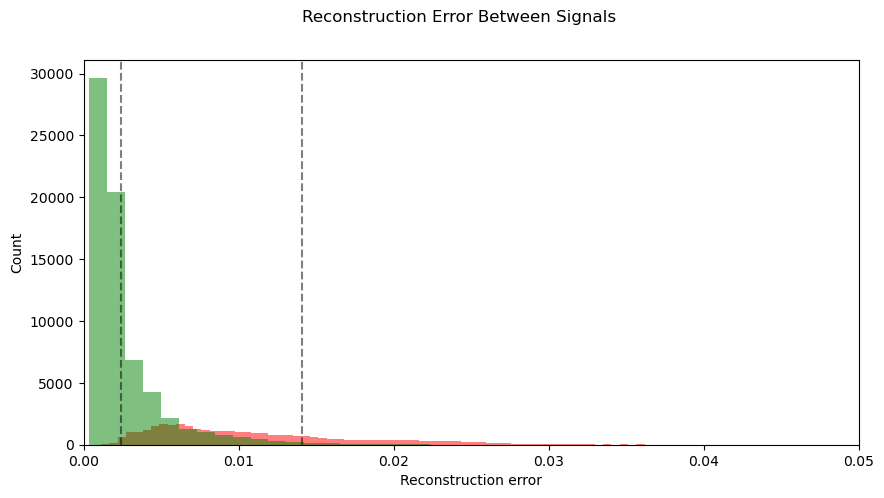

In [141]:
test_signals_3 = autoencoder3.predict(X_test)
reconstruction_error_3 = np.mean(np.square(X_test - test_signals_3), axis=1)  # mse for every signal sample

anomaly_q001_3 = np.quantile(reconstruction_error_3[anomaly_ids], 0.01)
normal_q099_3 = np.quantile(reconstruction_error_3[normal_ids], 0.99)

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(reconstruction_error_3[anomaly_ids], bins=600, color="red", alpha=0.5)
ax.hist(reconstruction_error_3[normal_ids], bins=300, color="green", alpha=0.5)

ax.axvline(x=anomaly_q001_3, color="black", alpha=0.5, linestyle="--")
ax.axvline(x=normal_q099_3, color="black", alpha=0.5, linestyle="--")

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Count")

fig.suptitle("Reconstruction Error Between Signals")

ax.set_xlim([0, 0.05])

plt.show()

In [143]:
checkpoint_cb_4 = tf.keras.callbacks.ModelCheckpoint("model_cp4_new_4.keras", save_best_only=True)
early_stopping_cb_4 = tf.keras.callbacks.EarlyStopping(patience=10,
                                                       min_delta=0,
                                                       restore_best_weights=True)

log_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end = lambda epoch, logs: print(f"Epoch {epoch+1} | Loss: {round(logs['loss'], 6)} | Val Loss: {round(logs['val_loss'], 6)}")
    if (epoch + 1) % 5 == 0 else None
)

optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.999)

input_shape = (X_train.shape[1], )  # signal length

encoder4 = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(64, activation=layers.LeakyReLU(alpha=0.01)),
    layers.BatchNormalization(),
    layers.Dense(48, activation=layers.LeakyReLU(alpha=0.01)),
    layers.BatchNormalization(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),  # laten space
    layers.BatchNormalization()
])

decoder4 = models.Sequential([
    layers.Dense(48, activation=layers.LeakyReLU(alpha=0.01), input_shape=(32,)),
    layers.BatchNormalization(),
    layers.Dense(64, activation=layers.LeakyReLU(alpha=0.01)),
    layers.BatchNormalization(),
    layers.Dense(input_shape[0], activation='sigmoid')
])

autoencoder4 = models.Sequential([encoder4, decoder4])

autoencoder4.compile(optimizer=optimizer, loss='mse')

autoencoder4.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)           │ ?                           │          60,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_25 (Sequential)           │ ?                           │          61,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,952 (476.38 KB)

 Trainable params: 121,440 (474.38 KB)

 Non-trainable params: 512 (2.00 KB)

In [145]:
history4 = autoencoder4.fit(
    X_train, 
    X_train,
    epochs=150, 
    batch_size=128, 
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint_cb_4, early_stopping_cb_4, log_callback],
    verbose=0
)

Epoch 5 | Loss: 0.004631 | Val Loss: 0.004387
Epoch 10 | Loss: 0.003071 | Val Loss: 0.002716
Epoch 15 | Loss: 0.002651 | Val Loss: 0.002863
Epoch 20 | Loss: 0.002462 | Val Loss: 0.002207
Epoch 25 | Loss: 0.002337 | Val Loss: 0.002116
Epoch 30 | Loss: 0.002228 | Val Loss: 0.002055
Epoch 35 | Loss: 0.002184 | Val Loss: 0.001998
Epoch 40 | Loss: 0.002141 | Val Loss: 0.001913
Epoch 45 | Loss: 0.002111 | Val Loss: 0.001966
Epoch 50 | Loss: 0.002095 | Val Loss: 0.001897
Epoch 55 | Loss: 0.002096 | Val Loss: 0.001916
Epoch 60 | Loss: 0.002062 | Val Loss: 0.001883
Epoch 65 | Loss: 0.002045 | Val Loss: 0.001827
Epoch 70 | Loss: 0.002043 | Val Loss: 0.001882


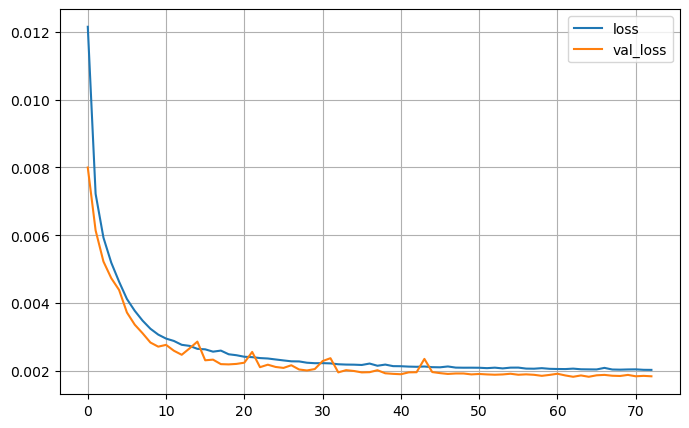

In [147]:
pd.DataFrame(history4.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [149]:
test_signals_4 = autoencoder4.predict(X_test)
reconstruction_error_4 = np.mean(np.square(X_test - test_signals_4), axis=1)  # mse for every signal sample

anomaly_q001_4 = np.quantile(reconstruction_error_4[anomaly_ids], 0.01)
normal_q099_4 = np.quantile(reconstruction_error_4[normal_ids], 0.99)

3223/3223 ━━━━━━━━━━━━━━━━━━━━ 3s 992us/step


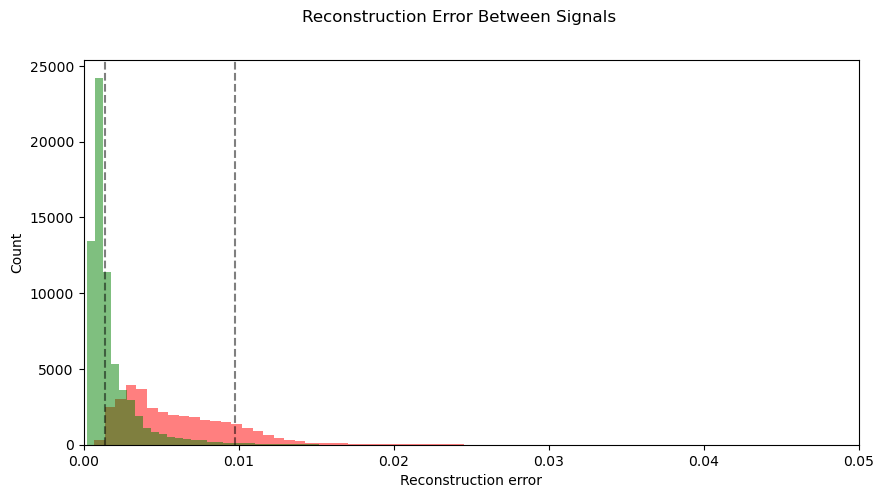

In [155]:
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(reconstruction_error_4[anomaly_ids], bins=800, color="red", alpha=0.5)
ax.hist(reconstruction_error_4[normal_ids], bins=1000, color="green", alpha=0.5)

ax.axvline(x=anomaly_q001_4, color="black", alpha=0.5, linestyle="--")
ax.axvline(x=normal_q099_4, color="black", alpha=0.5, linestyle="--")

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Count")

fig.suptitle("Reconstruction Error Between Signals")

ax.set_xlim([0, 0.05])

plt.show()

In [225]:
autoencoder3.save("final_model.keras")

In [189]:
final_model = models.load_model("models/final_model.keras", custom_objects={'LeakyReLU': layers.LeakyReLU(alpha=0.01)})

In [235]:
test_signals = final_model.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - test_signals), axis=1)  # mse for every signal sample

anomaly_q001 = np.quantile(reconstruction_error[anomaly_ids], 0.01)
normal_q099 = np.quantile(reconstruction_error[normal_ids], 0.9)

3223/3223 ━━━━━━━━━━━━━━━━━━━━ 3s 989us/step


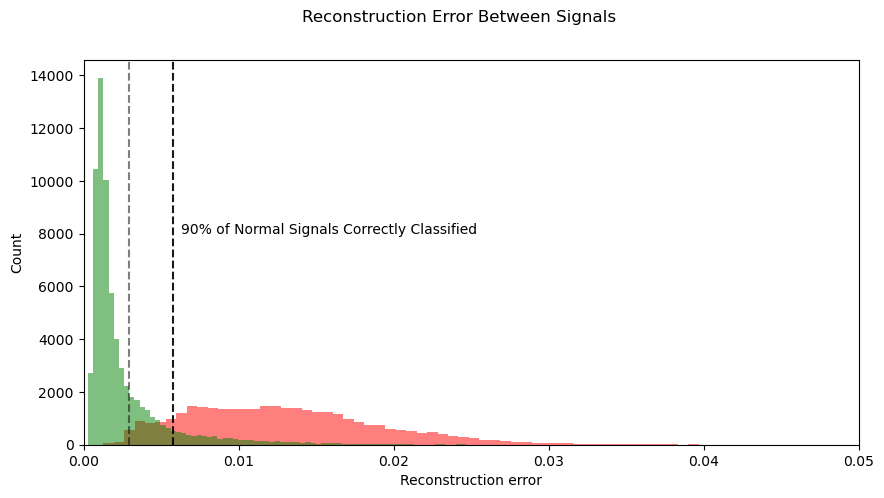

In [261]:
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(reconstruction_error[anomaly_ids[0]], bins=100, color="red", alpha=0.5)
ax.hist(reconstruction_error[normal_ids[0]], bins=2000, color="green", alpha=0.5)

ax.axvline(x=anomaly_q001, color="black", alpha=0.5, linestyle="--")
ax.axvline(x=normal_q099, color="black", alpha=0.9, linestyle="--")

ax.annotate("90% of Normal Signals Correctly Classified", (normal_q099 + 0.0005, 8000))

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Count")

fig.suptitle("Reconstruction Error Between Signals")

ax.set_xlim([0, 0.05])

plt.show()

fig.savefig("graphs/threshold.png")

In [241]:
normal_q099

0.005748230515145041

In [243]:
anomaly_q001_3 = 0.0029483
normal_q090 = 0.005748231

class AnomalyDetector:

    def __init__(self, path: str, anomaly_threshold: float):
        self.model = models.load_model(path, custom_objects={'LeakyReLU': layers.LeakyReLU})
        self.threshold = anomaly_threshold

    
    def predict(self, signal: np.array) -> int:
        reconstructed_signal = self.model.predict(self.fix_dimension(signal))
        error = self.calculate_error(signal, reconstructed_signal)
        return (error > self.threshold).astype(int)

    
    def fix_dimension(self, signal: np.array) -> np.array:
        return np.atleast_2d(signal)


    def calculate_error(self, X_original: np.array, X_reconstructed: np.array) -> np.array:
        return np.mean(np.square(X_original - X_reconstructed), axis=1)

In [245]:
anomaly_detector = AnomalyDetector("models/final_model.keras", normal_q099)

In [247]:
y_pred = anomaly_detector.predict(X_test)

3223/3223 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


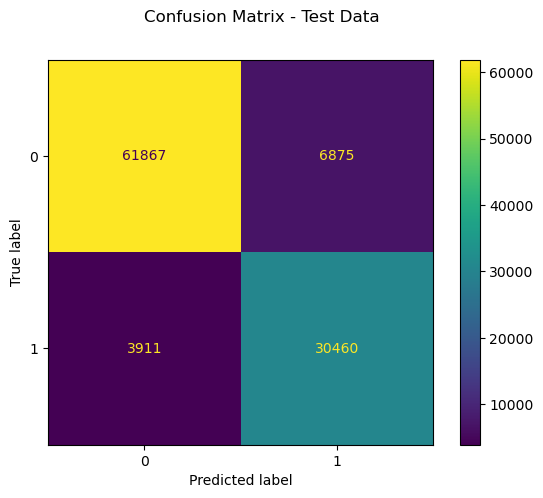

In [277]:
fig, ax = plt.subplots(figsize=(7,5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(values_format="d", ax=ax)

fig.suptitle("Confusion Matrix - Test Data")
plt.show()

fig.savefig("graphs/confusion_matrix.png")

In [251]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     68742
           1       0.82      0.89      0.85     34371

    accuracy                           0.90    103113
   macro avg       0.88      0.89      0.88    103113
weighted avg       0.90      0.90      0.90    103113



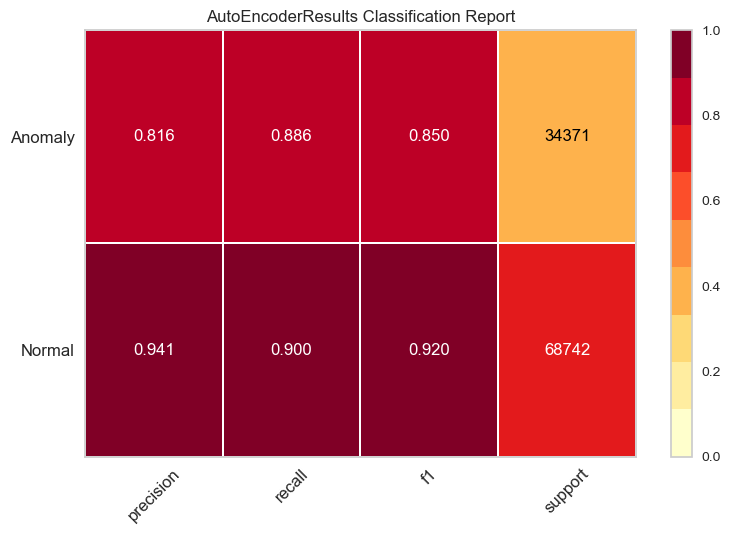

<Axes: title={'center': 'AutoEncoderResults Classification Report'}>

In [307]:
from yellowbrick.classifier import ClassificationReport
from sklearn.base import BaseEstimator, ClassifierMixin

class AutoEncoderResults(BaseEstimator, ClassifierMixin):

    def __init__(self):
        self._estimator_type = "classifier"
        self.classes_ = ["Normal", "Anomaly"]
        
    def predict(self, X):
        return y_pred



model = AutoEncoderResults()
visualizer = ClassificationReport(model, support=True)

visualizer.score(X=None, y=y_test)

plt.savefig("graphs/classification_report.png")
visualizer.show()

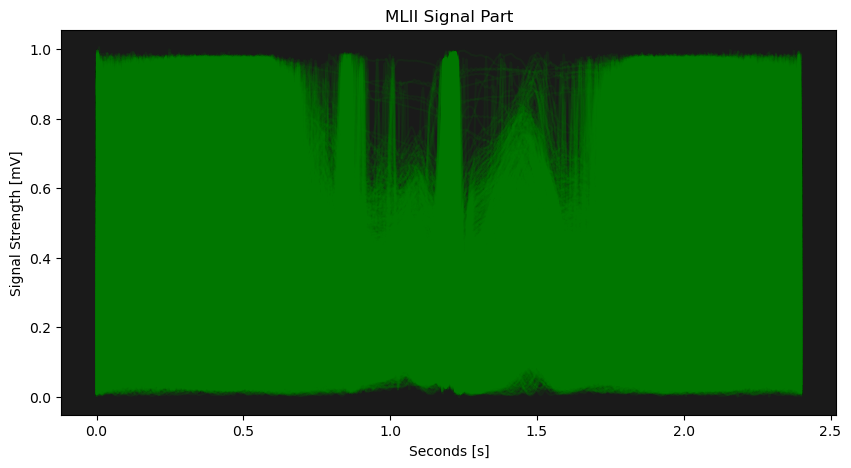

In [253]:
fig, ax = plt.subplots(figsize=(10,5))

for _ in range(10000):
    plot_signal_data(ax, tt, X_train[np.random.randint(0, len(X_train))], plot_kws={"alpha": 0.1})

plt.show()